# Task 2
## Conecta 4 con Temporal Difference Learning
### Integrantes:
- Diego Leiva
- Marta Ramirez
- Gustavo Gonzales
- Pablo Orellana

**Importar librerias necesarias**

In [1]:
from kaggle_environments import evaluate, make
import matplotlib.pyplot as plt
import numpy as np
import random

**Crear un entorno de Conecta 4**

In [2]:
env = make("connectx", debug=True)
env.render(mode="ipython")

### AGENTES MINIMAX

**AGENTE MINIMAX SIN PODA**

Definir funciones de evaluacion de ventana

In [3]:
def check_window(window, num_discs, piece, config):
    """
    Comprueba si una ventana contiene el número especificado de discos de una pieza dada.

    Args:
        window (list): La ventana a comprobar.
        num_discs (int): El número de discos en la ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        bool: Verdadero si la ventana contiene el número especificado de discos de la pieza dada, Falso en caso contrario.
    """
    if window.count(piece) == num_discs and window.count(0) == config.inarow - num_discs:
        return True
    else:
        return False 

In [4]:

def count_windows(grid, num_discs, piece, config):
    """
    Cuenta el número de ventanas en la cuadrícula que contienen cierto número de discos de una pieza dada.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        num_discs (int): El número de discos en una ventana.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: El número de ventanas.
    """
    num_windows = 0

    # horizontal
    for row in range(config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[row, col:col + config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # vertical
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns):
            window = list(grid[row:row + config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente positiva
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row + config.inarow), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1

    # diagonal con pendiente negativa
    for row in range(config.inarow - 1, config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row - config.inarow, -1), range(col, col + config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows



Definir la heuristica a utilizar

In [5]:
def get_heuristic(grid, mark, config):
    """
    Calcula la puntuación heurística para un estado de cuadrícula dado.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        int: La puntuación heurística.
    """
    score = 0
    for i in range(config.inarow):
        num = count_windows(grid, i + 1, mark, config)
        score += (4 ** (i + 1)) * num
    for i in range(config.inarow):
        num_opp = count_windows(grid, i + 1, mark % 2 + 1, config)
        score -= (2 ** ((2 * i) + 3)) * num_opp
    return score


Definir funciones auxiliares

In [6]:

def drop_piece(grid, col, piece, config):
    """
    Inserta una pieza en la columna especificada de la cuadrícula del juego.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna donde insertar la pieza.
        piece (int): La pieza del jugador (1 o 2).
        config (Config): La configuración del juego.

    Returns:
        numpy.ndarray: La cuadrícula del juego actualizada.
    """
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    return next_grid


Implementar el algoritmo de minimax

In [7]:
def score_move_a(grid, col, mark, config, max_depth=1):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_b.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int, opcional): El número de pasos para mirar hacia adelante (Profundidad del arbol). Por defecto es 1.

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, mark, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_b(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = min(scores)
    return score


def score_move_b(grid, col, mark, config, max_depth):
    """
    Calcula la puntuación para un movimiento en la cuadrícula del juego utilizando la función score_move_a.

    Args:
        grid (numpy.ndarray): La cuadrícula del juego.
        col (int): La columna en la que hacer el movimiento.
        mark (int): La marca del jugador (1 o 2).
        config (Config): La configuración del juego.
        max_depth (int): El número de pasos a mirar hacia adelante (profundidad del arbol).

    Returns:
        int: La puntuación para el movimiento.
    """
    next_grid = drop_piece(grid, col, (mark % 2) + 1, config)
    valid_moves = [col for col in range(config.columns) if next_grid[0][col] == 0]
    if len(valid_moves) == 0 or max_depth == 0:
        score = get_heuristic(next_grid, mark, config)
        return score
    else:
        scores = [score_move_a(next_grid, col, mark, config, max_depth - 1) for col in valid_moves]
        score = max(scores)
    return score

**Definir el agente minimax**

In [8]:
def minimax_agent(obs, config):
    """
    Implementacion de un agente minimax sin poda para el juego conecta 4.

    Args:
        obs: Un objeto representando el estado actual del juego.
        config: Un objeto con los parametros de configuracion del juego.

    Returns:
        La columna que selecciono el agente para colocar su ficha.
    """
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    scores = dict(zip(valid_moves, [score_move_a(grid=grid, col=col, mark=obs.mark, config=config, max_depth=1) for col in valid_moves]))
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    return random.choice(max_cols)

**Probar el funcionamiento del agenete contra un agente aleatorio**

Antes de hacer la prueba es necesario aclarar algunas cosas del entorno ConnectX de la API de Kaggle
1. el comando **'run'** lleva ["Jugador 1", "Jugador 2"]
2. Jugador 1 es representado por la ficha celeste con una 'K'
3. Jugador 2 es representado por la ficha gris con un 'pato'
4. El jugador 1 siempre va primero

In [9]:
# Usar el agente minimax contra un agente aleatorio
env.run([minimax_agent,"random"])

env.render(mode="ipython")

Claramente el agente minimax no tuvo problema alguno para vencer al agente aleatorio

Codigo de referencia obtenido de:
- https://www.kaggle.com/code/sidagar/getting-1000-score-using-only-minimax
- https://www.kaggle.com/code/alexisbcook/one-step-lookahead

**Evaluando el modelo**

In [10]:
def win_rate(rewards):
    """
    Calcula la tasa de victoria basada en una lista de recompensas.

    Args:
        rewards (lista): Una lista de tuplas que representan las recompensas para cada juego jugado. Cada tupla contiene dos valores: el número de victorias y el número de derrotas.

    Returns:
        tupla: Una tupla que contiene la tasa de victoria como porcentaje para victorias y derrotas.
    """
    return sum(r[0] for r in rewards) / float(len(rewards)) * 100, sum(r[1] for r in rewards) / float(len(rewards)) * 100, 

In [11]:
def plot_win_count(win_rate1, agent1, win_rate2, agent2, episodes):
    """
    Grafica la cantidad de victorias de cada agente en el jeugo de conecta 4.

    Args:
        win_rate1 (float): Taza de exito del agente 1.
        agent1 (str): El nombre del agente 1.
        win_rate2 (float): Taza de exito del agente 2.
        agent2 (str): El nombre del agente 2.
        episodes (int): Cantidad total de iteraciones.

    Returns:
        None
    """
    # Calcula el conteo de victorias
    win_count1 = win_rate1 / 100 * episodes
    win_count2 = win_rate2 / 100 * episodes

    # Crea un gráfico de barras
    plt.bar([agent1, agent2], [win_count1, win_count2])
    plt.ylabel('Cantidad de Victorias')
    plt.title('Conteo de victorias para 2 agentes')

    # Muestra el gráfico
    plt.show()

In [12]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "random"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Aleatorio: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  100.0 %
Taza de éxito para el agente Aleatorio:  0.0 %


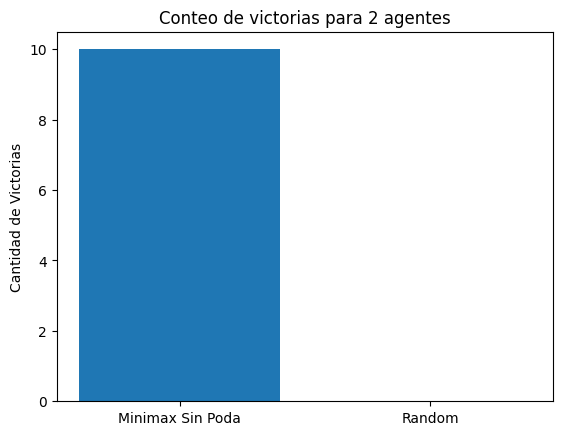

In [13]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Random", 10)

In [14]:
# Mostrar los resultados
win_rate_1, win_rate_2 = win_rate(evaluate("connectx", [minimax_agent, "negamax"], num_episodes=10))
print("Taza de éxito para el agente Minimax: ", win_rate_1, "%")
print("Taza de éxito para el agente Negamax: ", win_rate_2, "%")

Taza de éxito para el agente Minimax:  80.0 %
Taza de éxito para el agente Negamax:  20.0 %


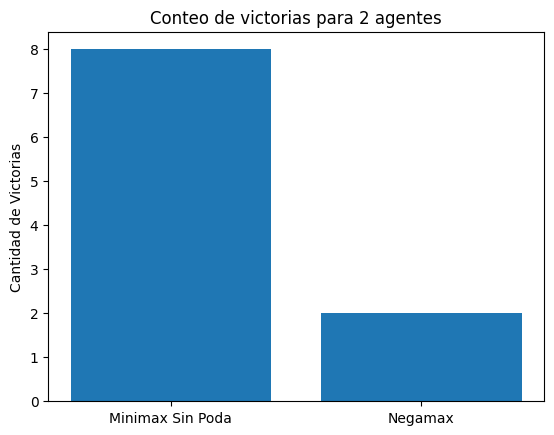

In [16]:
# Graficar los resultados
plot_win_count(win_rate_1, "Minimax Sin Poda", win_rate_2, "Negamax", 10)